In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from util.net_struct import get_feature_map, get_fc_graph_struc
from util.preprocess import build_loc_net, construct_data
from models.GDN import GDN
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats.mstats import winsorize

%matplotlib inline

In [2]:
dataset = 'eeg' #self.env_config['dataset'] 
train_df = pd.read_csv(f'./data/{dataset}/train.csv', sep=',', index_col=0)
test_df = pd.read_csv(f'./data/{dataset}/test.csv', sep=',', index_col=0)

# test_df = pd.read_csv('/zfsauton/project/public/Saswati/GLUE/test.csv')
# test_df = pd.read_csv('sub1000.csv', nrows=1000, index_col=0)

test_df.iloc[:,:-1] = winsorize(test_df.iloc[:,:-1].values, limits=(0.05, 0.05), axis=0)
train_df.iloc[:] = winsorize(train_df.iloc[:].values, limits=(0.05, 0.05), axis=0)

test_df.iloc[:,:-1] = StandardScaler().fit(train_df.iloc[:]).transform(test_df.iloc[:,:-1])
train_df.iloc[:] = StandardScaler().fit_transform(train_df.iloc[:])

print(np.unique(test_df.attack, return_counts=True))

seed=5
BATCH_SIZE=1024
SLIDE_WIN=32
dim=64
out_layer_num=1
SLIDE_STRIDE=1
topk=5
out_layer_inter_dim=128
val_ratio=0.2
decay=0
EPOCH=20
report='best'
PATH = './pretrained/eeg/best_09|15-03:21:37.pt'

train_config = {
        'batch': BATCH_SIZE,
        'epoch': EPOCH,
        'slide_win': SLIDE_WIN,
        'dim': dim,
        'slide_stride': SLIDE_STRIDE,
        'comment': 'eeg',
        'seed': seed,
        'out_layer_num': out_layer_num,
        'out_layer_inter_dim': out_layer_inter_dim,
        'decay': decay,
        'val_ratio': val_ratio,
        'topk': topk,
    }

(array([0, 1]), array([234375, 234375]))


In [3]:
feature_map = get_feature_map(dataset)
fc_struc = get_fc_graph_struc(dataset)

fc_edge_index = build_loc_net(fc_struc, list(test_df.columns), feature_map=feature_map)
fc_edge_index = torch.tensor(fc_edge_index, dtype = torch.long)

edge_index_sets = []
edge_index_sets.append(fc_edge_index)

model = GDN(edge_index_sets, len(feature_map), 
            dim=train_config['dim'], 
            input_dim=train_config['slide_win'],
            out_layer_num=train_config['out_layer_num'],
            out_layer_inter_dim=train_config['out_layer_inter_dim'],
            topk=train_config['topk'])

model.load_state_dict(torch.load(PATH)) #, map_location=torch.device('cpu'))
#model.eval()
#model = torch.load('./pretrained/eeg/best_08|17-16:51:11.pt', map_location=torch.device('cpu'))

<All keys matched successfully>

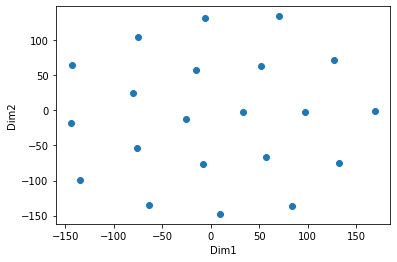

In [4]:
X = model.embedding.weight.detach().numpy()
X_embedded = TSNE(n_components=2).fit_transform(X)
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.xlabel("Dim1")
plt.ylabel("Dim2")
plt.show()

In [5]:
from torch.utils.data import DataLoader
from datasets.TimeDataset import TimeDataset
import random

cfg = {
            'slide_win': SLIDE_WIN,
            'slide_stride': SLIDE_STRIDE,
        }

train_dataset_indata = construct_data(train_df, feature_map, labels=0)
train_dataset = TimeDataset(train_dataset_indata, fc_edge_index, mode='train', config=cfg)
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=False, num_workers=0)

test_dataset_indata = construct_data(test_df, feature_map, labels=test_df.attack.tolist())
test_dataset = TimeDataset(test_dataset_indata, fc_edge_index, mode='test', config=cfg)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=0)

In [6]:
#from test import test as test_fn
import train
import importlib
import test
importlib.reload(test)
from test import test

In [7]:
_, test_result_list = test(model, test_dataloader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 458/458 [17:47<00:00,  2.33s/it]


In [8]:
_, train_result_list = test(model, train_dataloader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 458/458 [17:48<00:00,  2.33s/it]


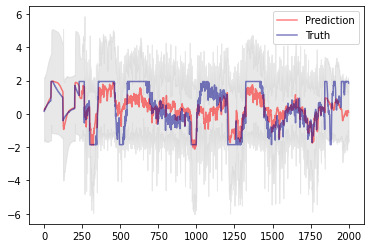

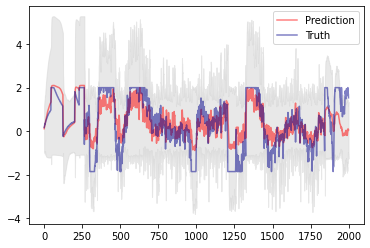

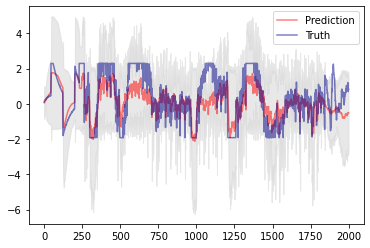

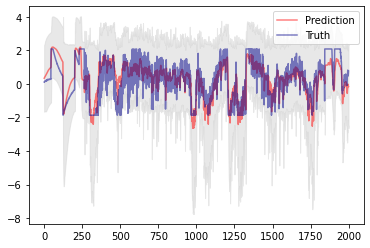

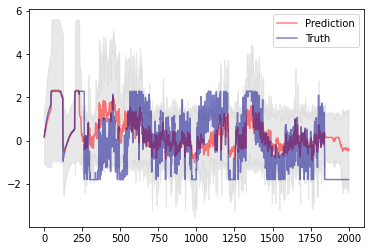

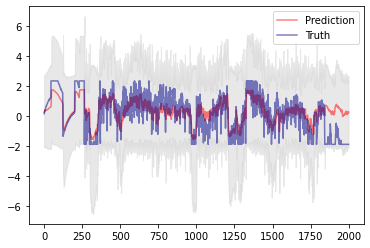

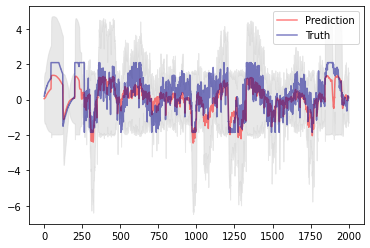

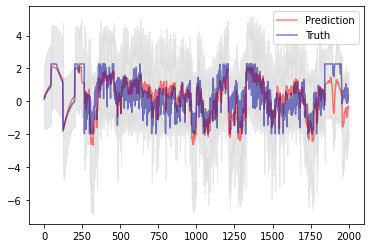

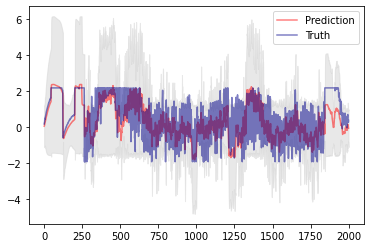

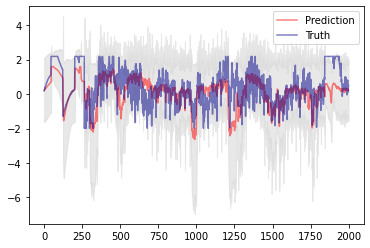

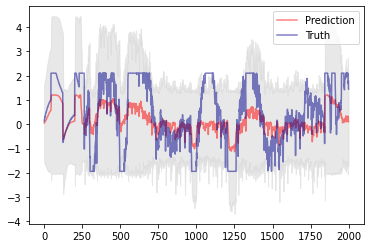

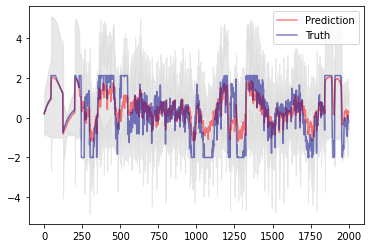

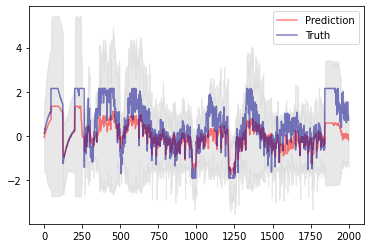

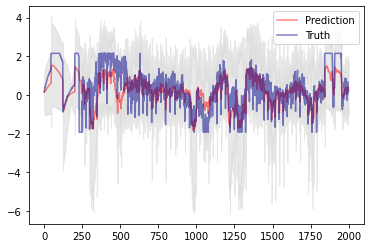

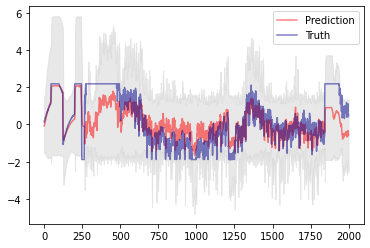

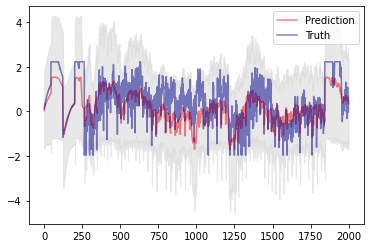

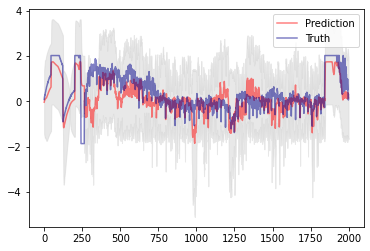

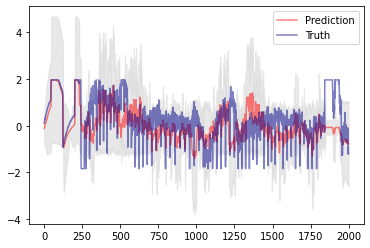

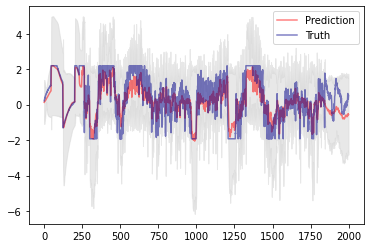

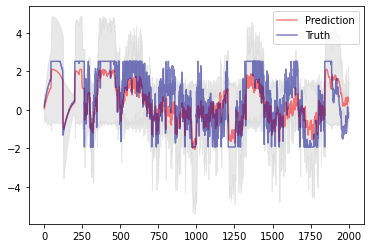

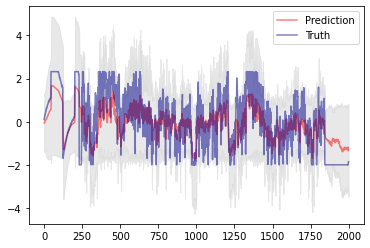

In [24]:
test_result = np.array(test_result_list[0]) # Predictions
truth_test = np.array(test_result_list[1])  # Ground truth

# minn = -2000
# maxx = -1
minn = 0
maxx = minn+2000
# GLUE predictions
for sensorID in range(21):
    x = np.arange(len(test_result[minn:maxx, sensorID, 0])) # mean
#     print(truth_test[:, sensorID])
    plt.plot(x, test_result[minn:maxx, sensorID, 0], c = 'red', alpha = 0.5, label = 'Prediction')
    plt.plot(x, truth_test[minn:maxx, sensorID], c = 'darkblue', alpha = 0.5, label = 'Truth')
    plt.fill_between(x, 
                     test_result[minn:maxx, sensorID, 0] + 1.96*np.sqrt(np.abs(test_result[minn:maxx, sensorID, 1])), 
                     test_result[minn:maxx, sensorID, 0] - 1.96*np.sqrt(np.abs(test_result[minn:maxx, sensorID, 1])), 
                     color = 'lightgrey', 
                     alpha = 0.5)
#     plt.ylim(np.median(test_result[minn:maxx, sensorID, 0]) - 10, np.median(test_result[minn:maxx, sensorID, 0]) + 10)
#     plt.ylim(-2,2)
    plt.legend()
    plt.show()

In [10]:
print(truth_test.shape) 
print(test_df.shape)
print(train_df.shape)

(468718, 21)
(468750, 22)
(468750, 21)


In [18]:
test_result = np.array(test_result_list[0])[:,:,0] # Predictions
truth_test = np.array(test_result_list[1])  # Ground truth

cutoff = len(test_result)//2
normal_mse = np.mean((test_result[:cutoff,:]-truth_test[:cutoff,:])**2, axis=1)
abnormal_mse = np.mean((test_result[cutoff:,:]-truth_test[cutoff:,:])**2, axis=1)

normal_mae = np.mean(np.abs(test_result[:cutoff,:]-truth_test[:cutoff,:]), axis=1)
abnormal_mae = np.mean(np.abs(test_result[cutoff:,:]-truth_test[cutoff:,:]), axis=1)

In [19]:
from gaussian_loss import gaussian_nll_loss

test_var = np.array(test_result_list[0])[:,:,1] # Predictions
test_mean = np.array(test_result_list[0])[:,:,0] # Predictions

normal_gnll = gaussian_nll_loss(torch.from_numpy(test_mean[:cutoff]), 
                                torch.from_numpy(truth_test[:cutoff]), 
                                torch.from_numpy(test_var[:cutoff]),
                                reduction='none').numpy()
abnormal_gnll = gaussian_nll_loss(torch.from_numpy(test_mean[cutoff:]), 
                                  torch.from_numpy(truth_test[cutoff:]), 
                                  torch.from_numpy(test_var[cutoff:]),
                                  reduction='none').numpy()

In [20]:
train_var = np.array(train_result_list[0])[:,:,1] # Predictions
train_mean = np.array(train_result_list[0])[:,:,0] # Predictions
truth_train = np.array(train_result_list[1])  # Ground truth

train_gnll = gaussian_nll_loss(torch.from_numpy(train_mean), 
                                torch.from_numpy(truth_train), 
                                torch.from_numpy(train_var),
                                reduction='none').numpy()
train_mse = np.mean((train_mean-truth_train)**2, axis=0)

[ 0.66571104  0.745752    0.50872359 ... -0.50613575 -0.33519088
 -0.33176925]
[ 0.57017464  0.59819118  0.46081234 ... -0.39103579 -0.17922778
 -0.18628291]


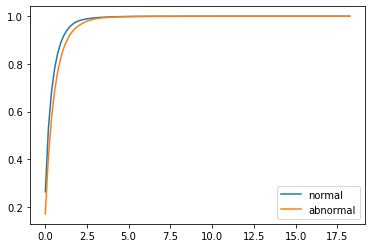

In [38]:
print(abnormal_mse-normal_mse)
print(abnormal_mae-normal_mae)

# plt.plot(np.mean(normal_gnll-train_thresh, axis=1))
# # plt.show()
# plt.plot(np.mean(abnormal_gnll-train_thresh, axis=1))
# plt.show()

# plt.scatter(np.arange(len(normal_mse)), normal_mae, label='normal', alpha=.2)
# plt.scatter(np.arange(len(normal_mse))+len(normal_mse), abnormal_mae, label='abnormal', alpha=.2)
# plt.plot(train_mse, label='train')

values, bin_edges = np.histogram(normal_mse, bins=100)
cumulative = np.cumsum(values)
cumulative = cumulative/len(normal_mse)
plt.plot(bin_edges[:-1], cumulative, label='normal')

values, bin_edges = np.histogram(abnormal_mse, bins=100)
cumulative = np.cumsum(values)
cumulative = cumulative/len(abnormal_mse)
plt.plot(bin_edges[:-1], cumulative, label='abnormal')

# plt.scatter(np.arange(len(normal_mse)), normal_mse, label='normal', alpha=.2)
# plt.scatter(np.arange(len(normal_mse))+len(normal_mse), abnormal_mse, label='abnormal', alpha=.2)

plt.legend(loc='lower right'); plt.show()
